# Import Libraries

In [295]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [296]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
%cd /content/drive/MyDrive/Data Science Portfolio/Amazon Echo Sentiment Analysis

/content/drive/MyDrive/Data Science Portfolio/Amazon Echo Sentiment Analysis


# Load Data

In [298]:
reviews_df = pd.read_csv('amazon_alexa.tsv', sep = '\t')

In [299]:
reviews_df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


# EDA

In [300]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [301]:
reviews_df[reviews_df['verified_reviews'].isna()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [302]:
# drop nan value
reviews_df.dropna(inplace = True)

In [303]:
# mean review is 4.4, feedback is almost 1
reviews_df.describe()

,rating,feedback
count,3149.000000,3149.000000
mean,4.463957,0.918704
std,1.067773,0.273332
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [304]:
# check "verified_reviews" column
reviews_df["verified_reviews"]

0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3145    Perfect for kids, adults and everyone in betwe...
3146    Listening to music, searching locations, check...
3147    I do love these things, i have them running my...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3149, dtype: object

<Axes: >

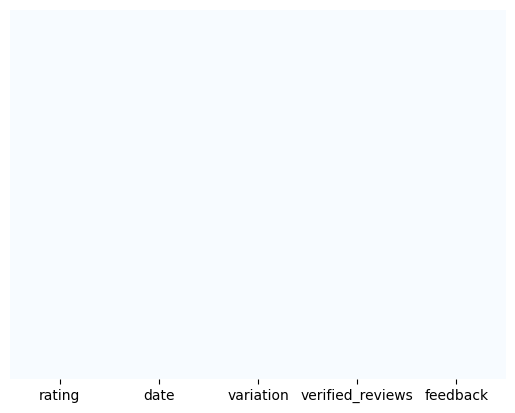

In [305]:
# check null values
sns.heatmap(reviews_df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues' )

array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'feedback'}>]], dtype=object)

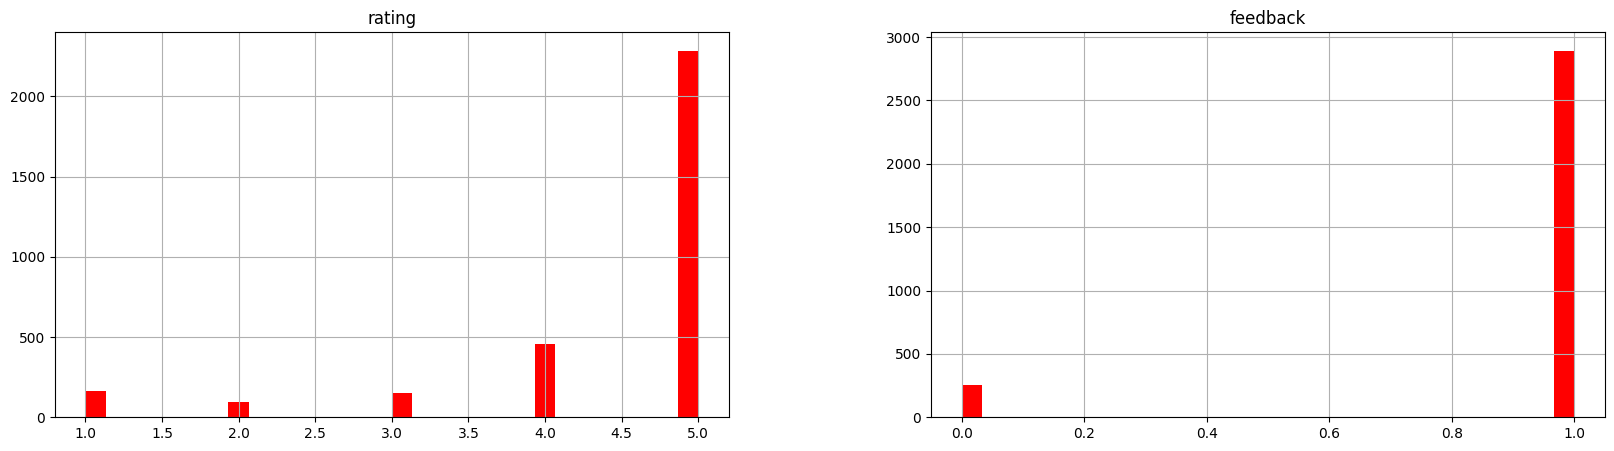

In [306]:
# distribution of 'rating' & 'feedback' columns
reviews_df.hist(bins = 30, figsize = (20,5), color = 'r')

In [307]:
reviews_df['feedback'].value_counts()
# the 'feedback' column shows imbalance

feedback
1    2893
0     256
Name: count, dtype: int64

In [308]:
# create column with length of reviews
reviews_df['length'] = reviews_df['verified_reviews'].apply(len)

In [309]:
reviews_df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


<Axes: >

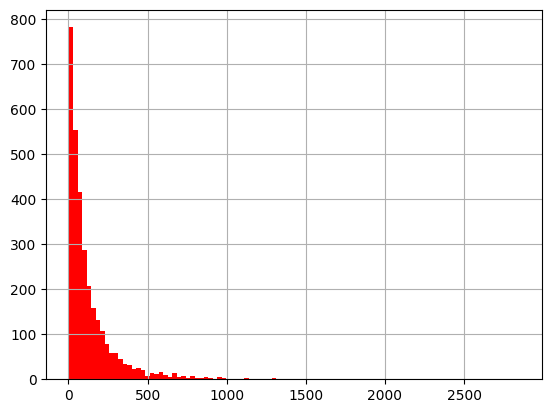

In [310]:
# distribution of 'length' column
reviews_df['length'].hist(bins = 100, color = 'r')

In [311]:
reviews_df.length.describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [312]:
# check the longest review
reviews_df.loc[reviews_df['length'] == 2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

In [313]:
# check the shortest review
reviews_df.loc[reviews_df['length'] == 1]['verified_reviews'].iloc[0]

'😍'

In [314]:
# create 'positive' dataframe
positive = reviews_df[reviews_df['feedback'] == 1]

In [315]:
# create 'negative' dataframe
negative = reviews_df[reviews_df['feedback'] == 0]

<Axes: xlabel='rating', ylabel='count'>

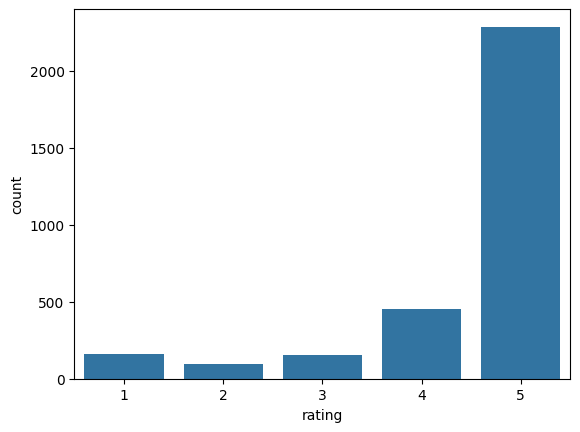

In [316]:
# rate distribution
sns.countplot(x = 'rating', data = reviews_df)

<ipython-input-317-f61905365fea>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'variation', y = 'rating', data = reviews_df, palette = 'deep')


<Axes: xlabel='variation', ylabel='rating'>

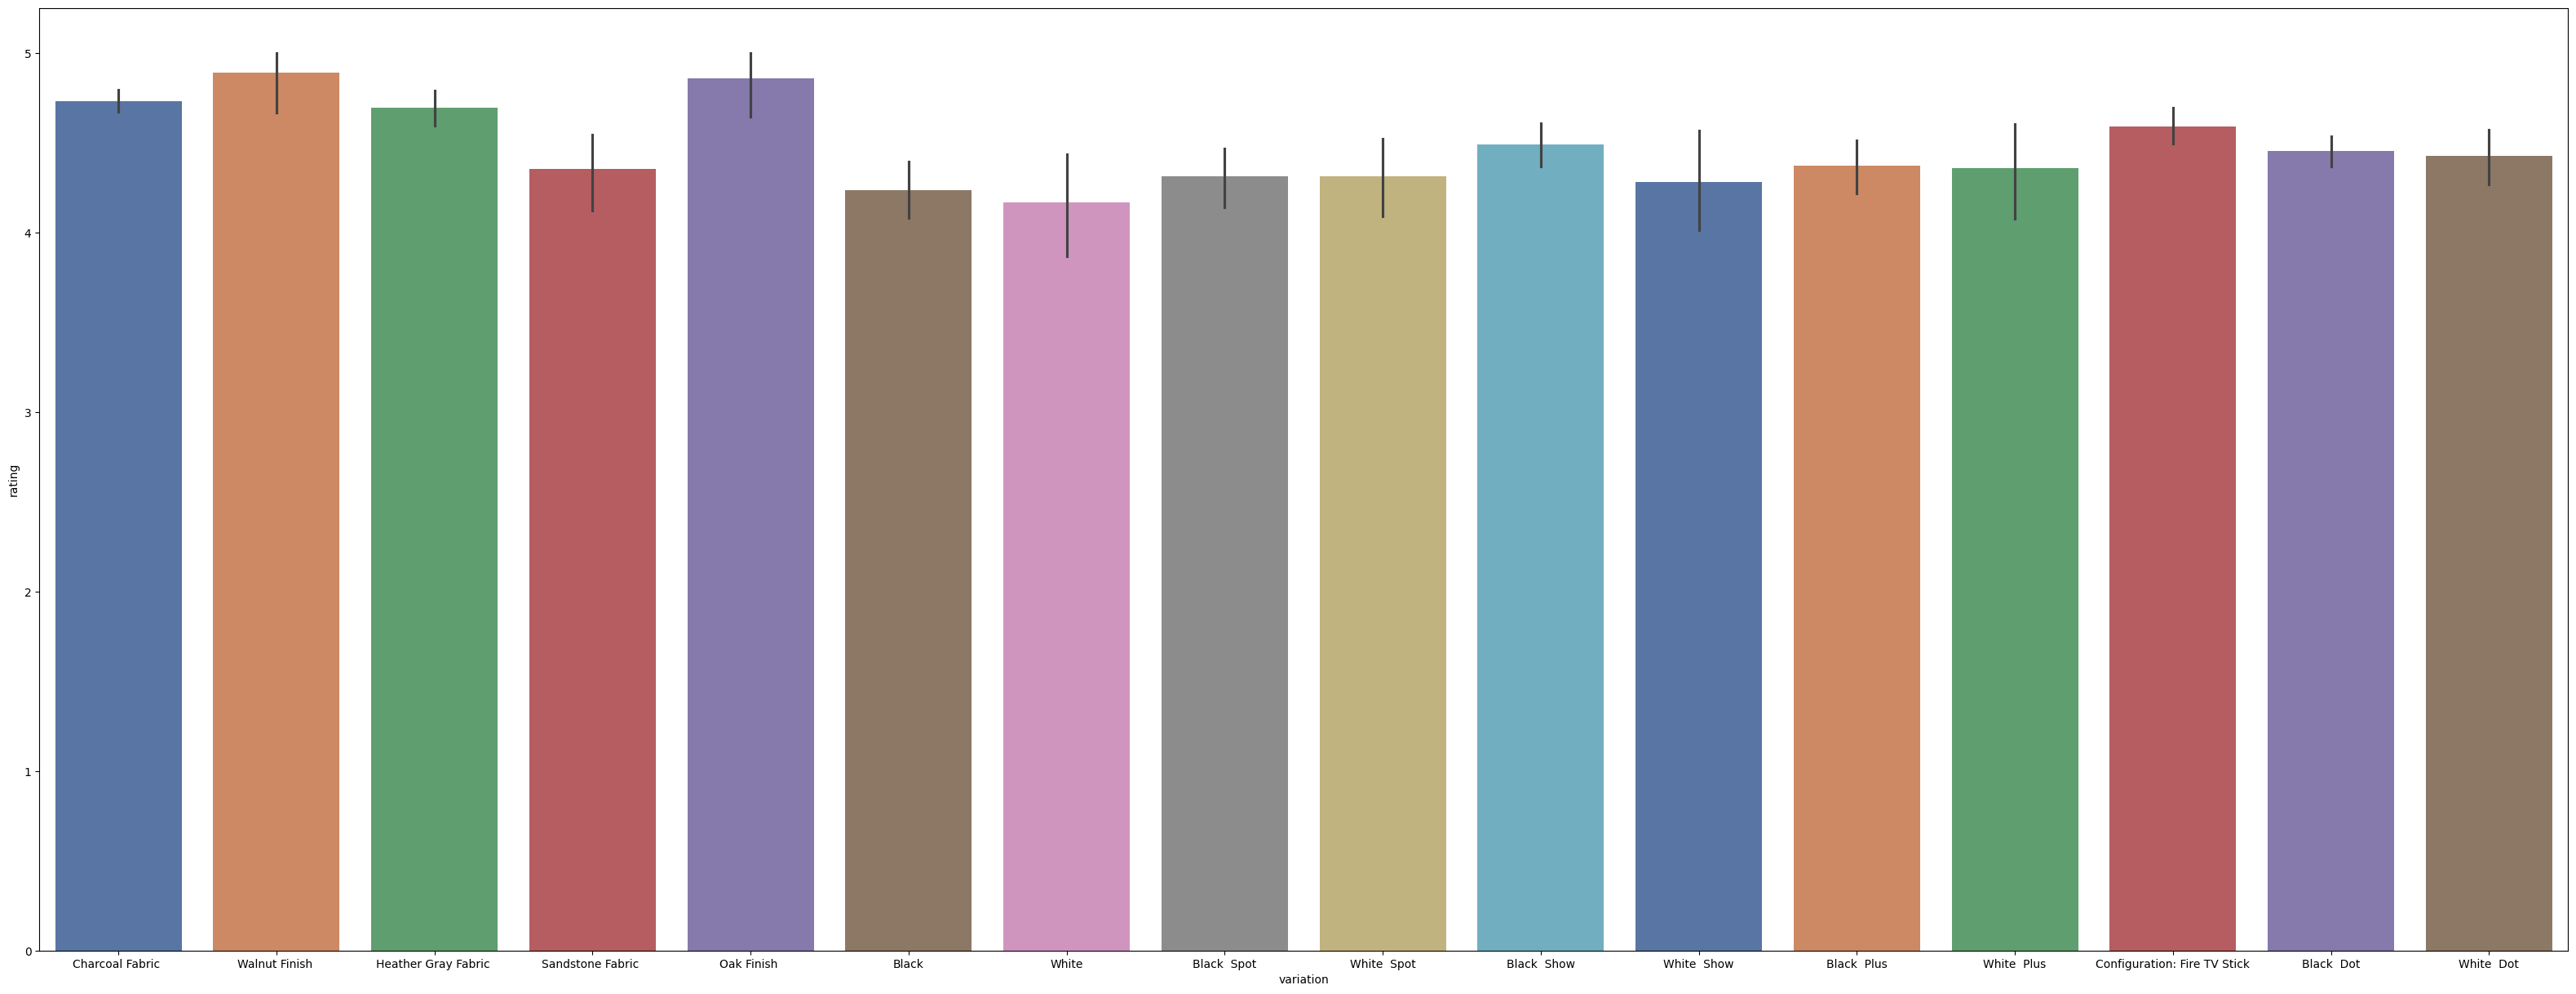

In [317]:
# varaiton distribution
plt.figure(figsize = (40,15))
sns.barplot(x = 'variation', y = 'rating', data = reviews_df, palette = 'deep')

In [318]:
# check 'verified_reviews' columns
sentences = reviews_df['verified_reviews'].to_list()
sentences

['Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.',
 'Music',
 'I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet.',
 "I think this is the 5th one I've

In [319]:
sentences_as_one_string = ''.join(sentences)

In [320]:
sentences_as_one_string

'Love my Echo!Loved it!Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.MusicI received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet.I think this is the 5th one I\'ve purchased. I\'m working on getting

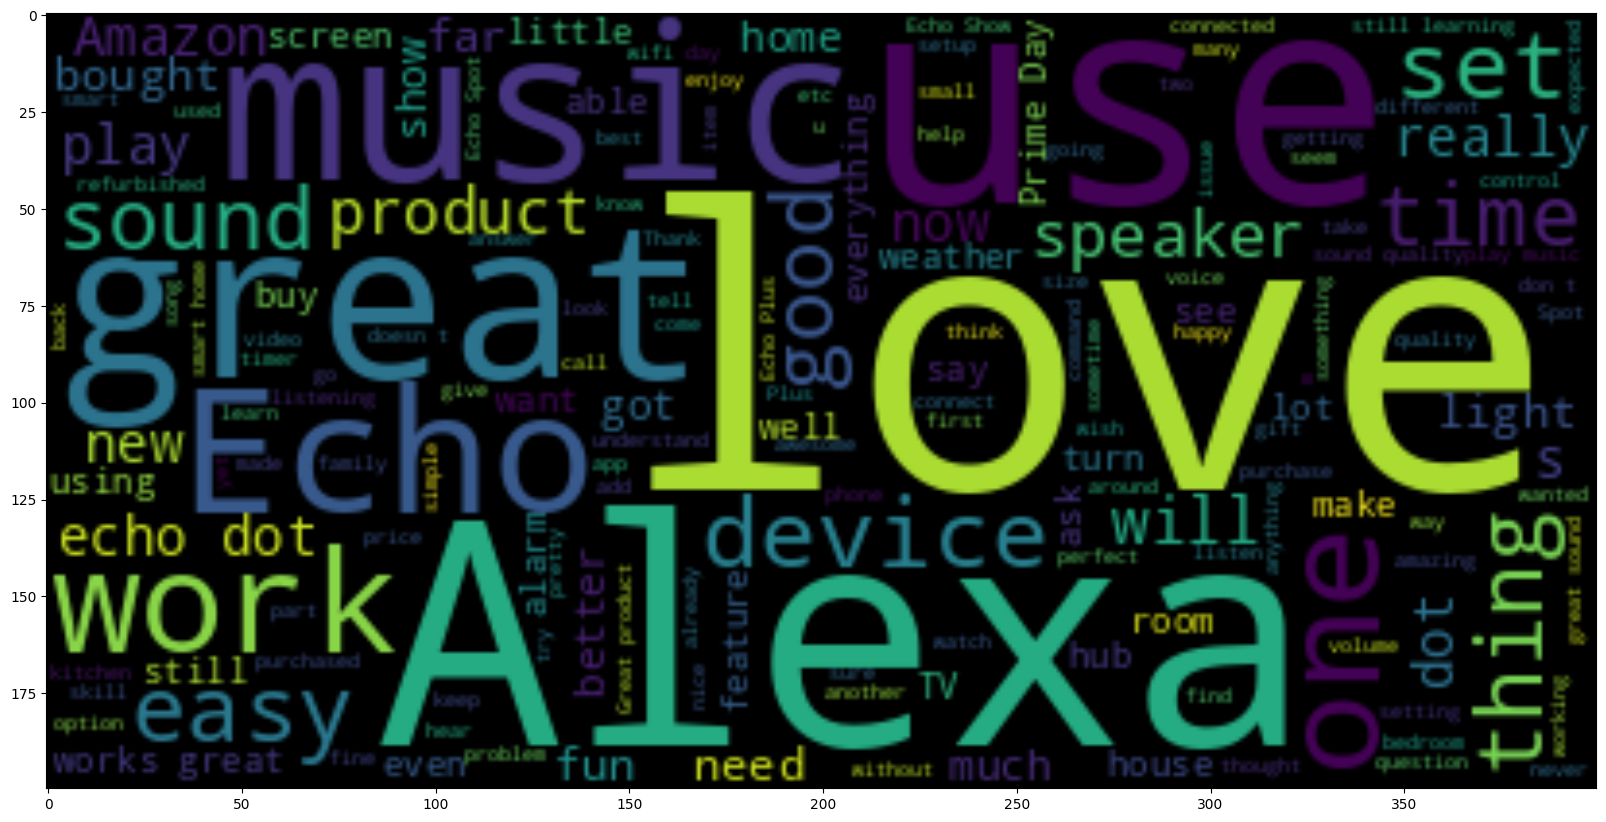

In [321]:
# word cloud visualization of verified reviews
plt.figure(figsize=(20,20))
plt.imshow(WordCloud(stopwords = set(STOPWORDS)).generate(sentences_as_one_string), interpolation = 'bilinear')

In [322]:
negative_list = negative['verified_reviews'].to_list()

In [323]:
negative_sentences_as_one_string = ''.join(negative_list)

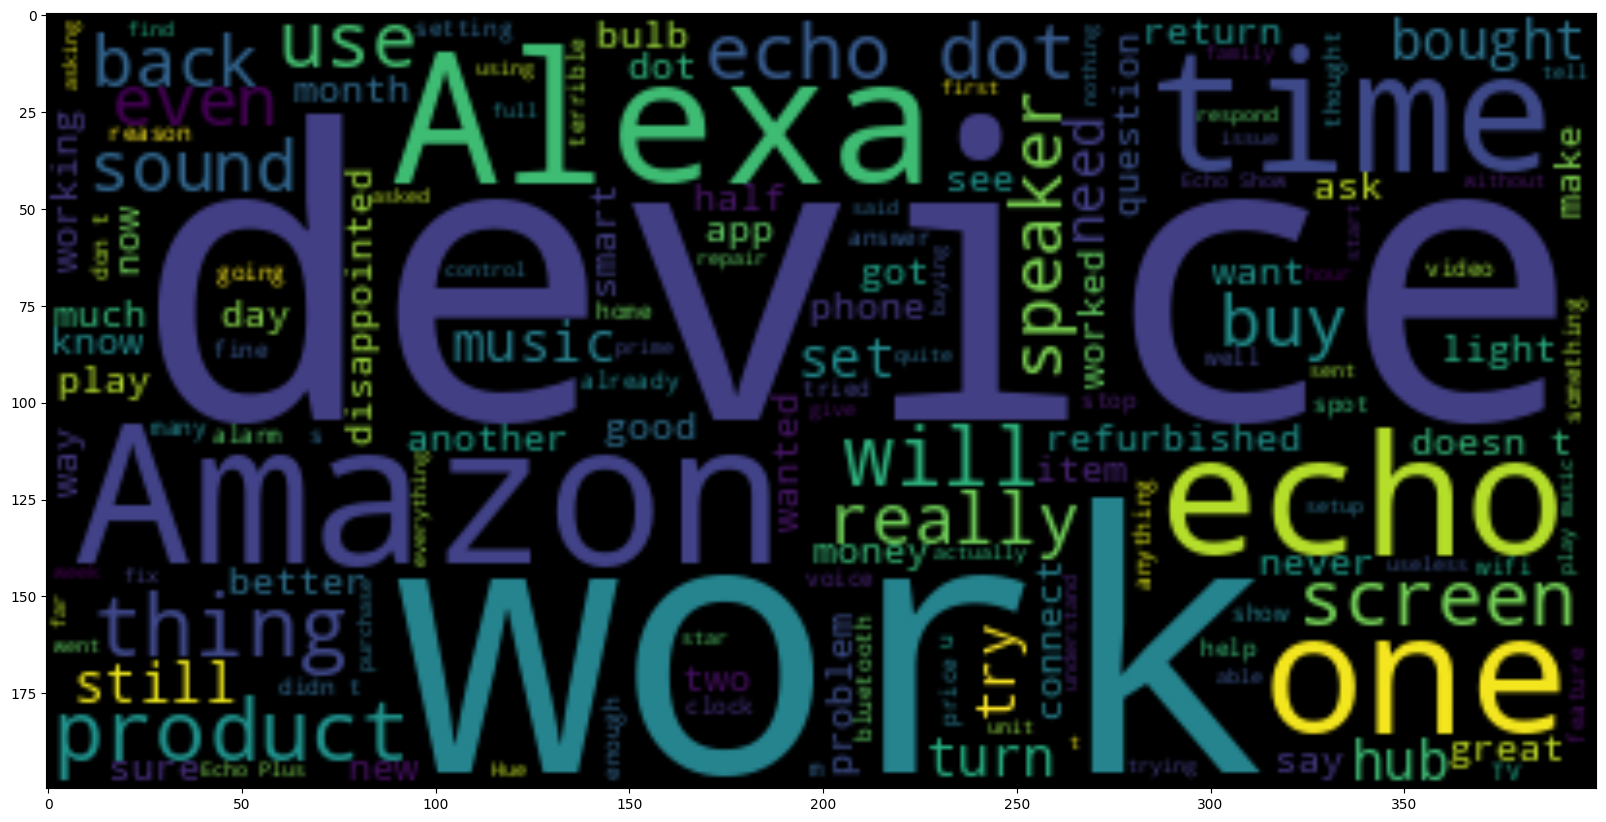

In [324]:
# word cloud visualization of negative verified reviews
plt.figure(figsize=(20,20))
plt.imshow(WordCloud(stopwords = set(STOPWORDS)).generate(negative_sentences_as_one_string), interpolation = 'bilinear')

# Data Cleaning & Preprocessing

In [325]:
# drop 'date', 'length', 'rating' columns
reviews_df.drop(['date', 'length', 'rating' ], axis = 1, inplace = True)

In [326]:
reviews_df['variation'].unique()

array(['Charcoal Fabric ', 'Walnut Finish ', 'Heather Gray Fabric ',
       'Sandstone Fabric ', 'Oak Finish ', 'Black', 'White',
       'Black  Spot', 'White  Spot', 'Black  Show', 'White  Show',
       'Black  Plus', 'White  Plus', 'Configuration: Fire TV Stick',
       'Black  Dot', 'White  Dot'], dtype=object)

In [327]:
# encode variation column
variation_dummies = pd.get_dummies(reviews_df['variation'], drop_first = True)

In [328]:
variation_dummies = variation_dummies.astype(int)

In [329]:
variation_dummies

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [330]:
# drop old 'variation' column
reviews_df.drop(['variation'], axis = 1, inplace = True)

In [331]:
# concatenate encoded column
reviews_df = pd.concat([reviews_df, variation_dummies], axis=1)

In [332]:
reviews_df.head(5)

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Remove Punctuation & Stop Words**

In [333]:
# create function to remove punctuation and stop words
def message_cleaning(message):
  punc_removed = [char for char in message if char not in string.punctuation]
  punc_removed_join = ''.join(punc_removed)
  punc_removed_clean = [word for word in punc_removed_join.split() if word.lower() not in stopwords.words('english')]
  return punc_removed_clean

In [334]:
vectorizer = CountVectorizer(analyzer = message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews_df['verified_reviews'])

In [335]:
# feature names
print(vectorizer.get_feature_names_out())

['072318' '1' '10' ... '😬' '😳' '🤓']


In [336]:
# convert count vectorized reviews to array
print(reviews_countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [337]:
# shape of count vectorized reviews
reviews_countvectorizer.shape

(3149, 5211)

In [338]:
reviews_df

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [367]:
# convert count vectorized reviews to dataframe
reviews = pd.DataFrame(reviews_countvectorizer.toarray())

In [340]:
# drop 'verified_reviews' column
reviews_df.drop(['verified_reviews'], axis = 1, inplace = True)

In [341]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   feedback                      3149 non-null   int64
 1   Black  Dot                    3149 non-null   int64
 2   Black  Plus                   3149 non-null   int64
 3   Black  Show                   3149 non-null   int64
 4   Black  Spot                   3149 non-null   int64
 5   Charcoal Fabric               3149 non-null   int64
 6   Configuration: Fire TV Stick  3149 non-null   int64
 7   Heather Gray Fabric           3149 non-null   int64
 8   Oak Finish                    3149 non-null   int64
 9   Sandstone Fabric              3149 non-null   int64
 10  Walnut Finish                 3149 non-null   int64
 11  White                         3149 non-null   int64
 12  White  Dot                    3149 non-null   int64
 13  White  Plus                   3149 non

In [342]:
reviews_df.reset_index(drop=True, inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [343]:
# concatenate reviews_df with reviews(count vectorized reviews)
reviews_df = pd.concat([reviews_df, reviews], axis=1)

In [344]:
reviews_df.head()

,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Resampling

In [345]:
# define feature and target
X = reviews_df.drop(['feedback'], axis = 1)
y = reviews_df['feedback']

In [346]:
X.columns = X.columns.astype(str)

In [347]:
# define the resampling strategy
resampler = SMOTETomek(smote=SMOTE(sampling_strategy={0: 1500}), random_state=24)

In [348]:
# apply the resampling strategy to the data
X_resampled, y_resampled = resampler.fit_resample(X, y)

In [349]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Apply Multinomial Naive Bayes Classification Model

In [350]:
# multinomial naive bayes model training
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

<Axes: >

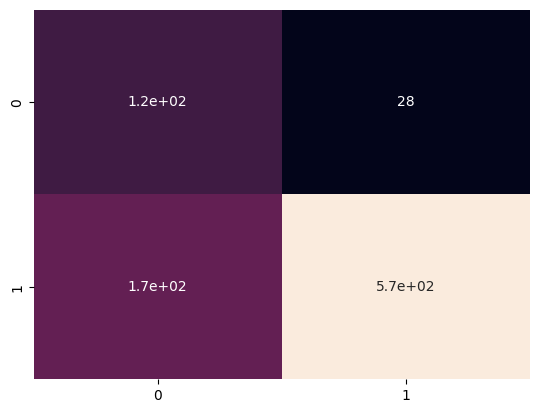

In [351]:
# confusion matrix heatmap for model evaluation
y_pred_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_pred_test, y_test )
sns.heatmap(cm, annot = True, cbar = False)

In [352]:
# classification report
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.41      0.81      0.55       145
           1       0.95      0.77      0.85       734

    accuracy                           0.78       879
   macro avg       0.68      0.79      0.70       879
weighted avg       0.86      0.78      0.80       879



#Apply Logistic Regression Classifier Model

In [353]:
# logistic regression model training
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

<Axes: >

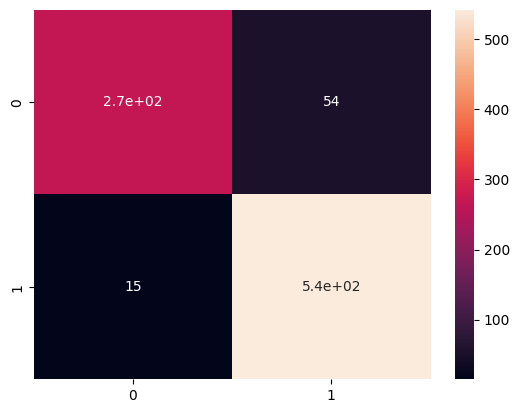

In [354]:
# confusion matrix heatmap for model evaluation
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True)

In [355]:
# model accuracy score
print(f'Accuracy {accuracy_score(y_pred, y_test)}')

Accuracy 0.9215017064846417


In [356]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       283
           1       0.97      0.91      0.94       596

    accuracy                           0.92       879
   macro avg       0.90      0.93      0.91       879
weighted avg       0.93      0.92      0.92       879



#Apply XGBoost Model

In [357]:
# XGBoost model training
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: >

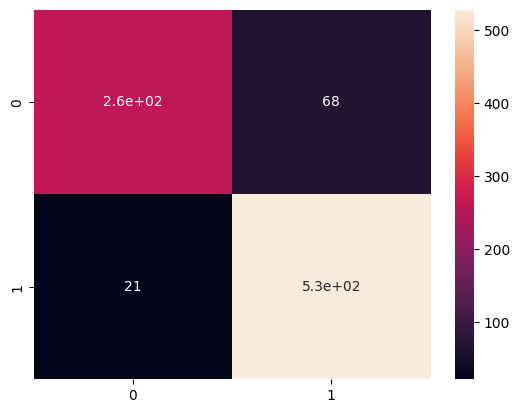

In [358]:
# confusion matrix heatmap for model evaluation
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True)

In [359]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       283
           1       0.96      0.89      0.92       596

    accuracy                           0.90       879
   macro avg       0.88      0.91      0.89       879
weighted avg       0.91      0.90      0.90       879

